### Bayesian Data Analysis, 3rd ed
##  Chapter 4, demo 1

Normal approximaton for Bioassay model.

In [1]:
import numpy as np
from scipy import optimize, stats

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# Bioassay data, (BDA3 page 86)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

In [5]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

The following demonstrates an alternative "bad" way of calcuting the posterior density p in a for loop. The vectorised statement above is numerically more efficient. In this small example however, it would not matter that much.

    p = np.empty((len(B),len(A))) # allocate space
    for i in range(len(A)):
        for j in range(len(B)):
            ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
            p[j,i] = np.prod(ilogit_abx_ij**y * ilogit_abx_ij**(n - y))

N.B. the vectorised expression can be made even more efficient, e.g. by optimising memory usage with in-place statements, but it would result in a less readable code.

In [6]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = - samp_A / samp_B

Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation. You may use optimisation routines below for checking your results. See help for scipy.optimize.minimize.

In [7]:
# define the optimised function
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

In [8]:
# compute the normal approximation density in grid
# this is just for the illustration

# Construct a grid array of shape (ngrid, ngrid, 2) from A and B. Although
# Numpy's concatenation functions do not support broadcasting, a clever trick
# can be applied to overcome this without unnecessary memory copies
# (see Numpy's documentation for strides for more information):
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# draw samples from the distribution
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

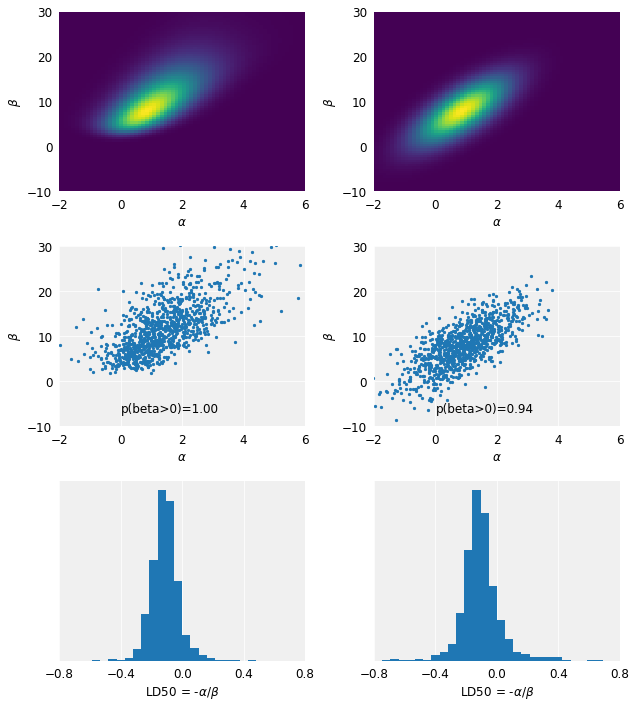

In [9]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples
ax = axes[1, 0]
ax.scatter(samp_A, samp_B, 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))

# plot the histogram of LD50
ax = axes[2, 0]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

# plot the posterior density for normal approx.
ax = axes[0, 1]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples from the normal approx.
ax = axes[1, 1]
ax.scatter(samp_norm[:,0], samp_norm[:,1], 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[2, 1]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
ax.hist(samp_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

fig.tight_layout()